## Bird Species Classifier

Now I will follow a similar process as in the PyTorch classification tutorial, this time finetuning on a dataset of birds and their species. 

### Dataset

The images used for finetuning are from the Cal Berkeley 2011 dataset, which includes 200 species of birds. I've used an 80/20 train test split. 

The dataset can be found on Kaggle here:
https://www.kaggle.com/datasets/kedarsai/bird-species-classification-220-categories/data?select=Test

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

### Loading data

In [23]:
# Need to research these normalization numbers more, I believe they are simply means or std. deviations of the rgb values for some distribution 

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [24]:
data_dir = 'data/CUB_200_2011'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# This line of code works with cuda but not with apple silicon
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Need to use this to use GPU
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

### Visualizing some images

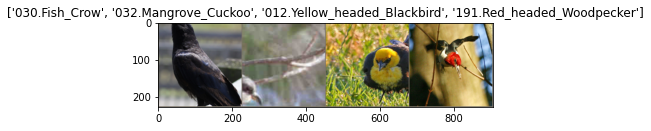

In [5]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Here we have a function that trains the model. We schedule the learning rate and save the best model 

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [26]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

In [27]:
# SSL certificate is invalid?? Not sure what this means but couldn't grab the pretrained model so used this as workaround
# Bypasses SSL certificate?
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


# Using 
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and Evaluate model

This takes quite long even for only 5 epochs. 

I tried training for 30 epochs below

In [31]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
train Loss: 1.3112 Acc: 0.6827
val Loss: 0.8753 Acc: 0.7738

Epoch 1/29
----------
train Loss: 1.2740 Acc: 0.6930
val Loss: 0.8699 Acc: 0.7810

Epoch 2/29
----------
train Loss: 1.2944 Acc: 0.6867
val Loss: 0.8707 Acc: 0.7780

Epoch 3/29
----------
train Loss: 1.2862 Acc: 0.6910
val Loss: 0.8681 Acc: 0.7797

Epoch 4/29
----------
train Loss: 1.2808 Acc: 0.6917
val Loss: 0.8543 Acc: 0.7839

Epoch 5/29
----------
train Loss: 1.2774 Acc: 0.6875
val Loss: 0.8738 Acc: 0.7831

Epoch 6/29
----------
train Loss: 1.2607 Acc: 0.6999
val Loss: 0.8526 Acc: 0.7831

Epoch 7/29
----------
train Loss: 1.2676 Acc: 0.6905
val Loss: 0.8538 Acc: 0.7822

Epoch 8/29
----------
train Loss: 1.3002 Acc: 0.6822
val Loss: 0.8735 Acc: 0.7738

Epoch 9/29
----------
train Loss: 1.2426 Acc: 0.6992
val Loss: 0.8644 Acc: 0.7763

Epoch 10/29
----------
train Loss: 1.2562 Acc: 0.6973
val Loss: 0.8321 Acc: 0.7843

Epoch 11/29
----------
train Loss: 1.2200 Acc: 0.7063
val Loss: 0.8638 Acc: 0.7843

Ep

### Visualizing some predictions 
Below are some images from the test set and their predicted species

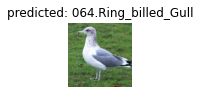

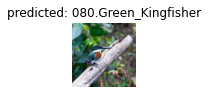

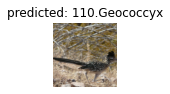

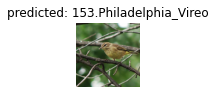

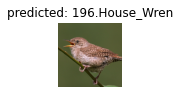

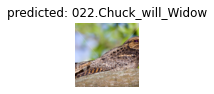

In [30]:
visualize_model(model_ft)